In [3]:
import sys 
import sklearn
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

The scikit-learn version is 0.20.3.


C:\Users\LENOVO\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
df = pd.read_csv('C:/Screening Test/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [6]:
df.shape

(2075259, 7)

In [8]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [10]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [8]:
# finding all columns that have nan:

droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [9]:
# filling nan with mean in any columns

for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [10]:
# another sanity check to make sure that there are not more any nan
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

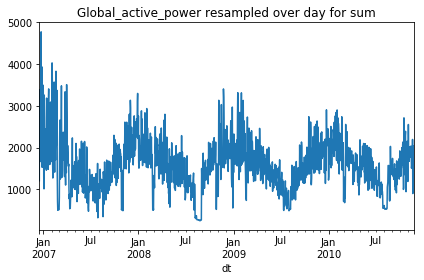

In [11]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.show()   


I will apply recurrent nueral network (LSTM) which is best suited for time-seriers and sequential problem.

*I will frame the supervised learning problem as predicting the Global_active_power at the current time (t) given the Global_active_power measurement and other features at the prior time step.*


In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

First, I split the prepared dataset into train and test sets. To speed up the training of the model (for the sake of the demonstration), we will only train the model on the first year of data, then evaluate it on the next 3 years of data.

In [20]:
## resampling of data over hour
#df_resample = df.resample('h').mean() 
#df_resample.shape

(34589, 7)

In [15]:
#normalization
 
values = df.values 


# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.374796   0.300719   0.376090   0.377593        0.0     0.0125   
2   0.478363   0.313669   0.336995   0.473029        0.0     0.0125   
3   0.479631   0.358273   0.326010   0.473029        0.0     0.0250   
4   0.480898   0.361151   0.340549   0.473029        0.0     0.0125   
5   0.325005   0.379856   0.403231   0.323651        0.0     0.0125   

   var7(t-1)   var1(t)  
1   0.548387  0.478363  
2   0.516129  0.479631  
3   0.548387  0.480898  
4   0.548387  0.325005  
5   0.548387  0.311787  


In [17]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (2066498, 1, 7) (2066498,)


Model architecture


1) LSTM with 100 neurons in the first visible layer
3) dropout 20%
4) 1 neuron in the output layer for predicting Global_active_power.
5) The input shape will be 1 time step with 7 features.
6) I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
7) The model will be fit for 20 training epochs with a batch size of 70.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 8760 samples, validate on 2066498 samples
Epoch 1/20
 - 47s - loss: 0.0126 - val_loss: 0.0022
Epoch 2/20
 - 42s - loss: 0.0032 - val_loss: 0.0012
Epoch 3/20
 - 45s - loss: 0.0023 - val_loss: 9.5576e-04
Epoch 4/20
 - 47s - loss: 0.0020 - val_loss: 8.5535e-04
Epoch 5/20
 - 43s - loss: 0.0018 - val_loss: 7.9863e-04
Epoch 6/20
 - 46s - loss: 0.0017 - val_loss: 7.7875e-04
Epoch 7/20
 - 44s - loss: 0.0016 - val_loss: 7.7525e-04
Epoch 8/20
 - 43s - loss: 0.0016 - val_loss: 7.4027e-04
Epoch 9/20
 - 43s - loss: 0.0016 - val_loss: 7.5011e-04
Epoch 10/20
 - 50s - loss: 0.0016 - val_loss: 7.4239e-04
Epoch 11/20
 - 48s - loss: 0.0015 - val_loss: 7.2703e-04
Epoch 12/20
 - 54s - loss: 0.0015 - val_loss: 7.2371e-04
Epoch 13/20
 - 50s - loss: 0.0015 - val_loss: 7

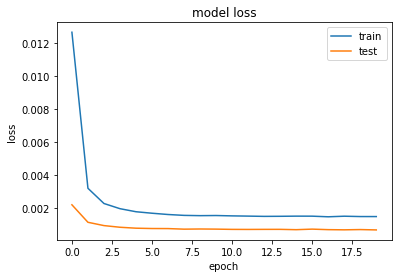

Test RMSE: 0.291


In [18]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

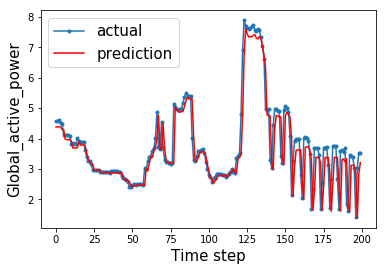

In [19]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()